In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# force GPU device
# os.environ["CUDA_VISIBLE_DEVICES"]='0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf

from keras.src.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.src.layers import SimpleRNN, LSTM, Dense, Dropout
from keras import Sequential, Input
from keras.optimizers import Adam
from keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

2024-07-17 23:10:57.519230: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
max_sequence_length = 100

In [3]:
checkpoint_path = f'saves/rnn/{max_sequence_length}_naivesplit'
model_path = f'{checkpoint_path}/model.keras'
log_path = f'{checkpoint_path}/log.csv'
history_path = f'{checkpoint_path}/history.npy'

# ensure directory exists
if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

load data from csv

In [4]:
data_directory = '/home/jrosendahl/datasets/cadets/sequences_export/'

data = []

labels = None
no_labels = None

distinct_features = [
'EVENT_ACCEPT', 'EVENT_BIND', 'EVENT_CHANGE_PRINCIPAL', 'EVENT_CLOSE', 'EVENT_CONNECT', 'EVENT_CREATE_OBJECT', 'EVENT_EXECUTE', 'EVENT_EXIT', 'EVENT_FCNTL', 'EVENT_FORK', 'EVENT_LINK', 'EVENT_LOGIN', 'EVENT_LSEEK', 'EVENT_MMAP', 'EVENT_MODIFY_FILE_ATTRIBUTES', 'EVENT_MODIFY_PROCESS', 'EVENT_MPROTECT', 'EVENT_OPEN', 'EVENT_OTHER', 'EVENT_READ', 'EVENT_RECVFROM', 'EVENT_RECVMSG', 'EVENT_RENAME', 'EVENT_SENDMSG', 'EVENT_SENDTO', 'EVENT_SIGNAL', 'EVENT_TRUNCATE', 'EVENT_UNLINK', 'EVENT_WRITE', 
]

# distinct_features = [ x[6:] for x in distinct_features ]
no_features = len(distinct_features)
print(f'Found {no_features} distinct features')

count = 0
count_long_sequences_splitted = 0
count_long_sequences_splitted_result = 0

for file_name in os.listdir(data_directory):
    count += 1
    if count % 50000 == 0:
        print(f'Loaded {count} sequences')
    with open(data_directory + file_name, 'r') as f:
        if file_name.count('_') == 2:
            label, _, _ = file_name.split('_')
        elif file_name.count('_') == 3:
            # pwd_mkdb
            label, tmp, _, _ = file_name.split('_')
            label += '_' + tmp
        else:
            print(f'Unknown file name format: {file_name}')
        #label = file_name.split('_')[0]

        # build dictionary with counts of events
        lines = f.readlines()
        # if sequence is longer than max_sequence_length, split into multiple sequences
        if len(lines) > max_sequence_length:
            count_long_sequences_splitted += 1
            for i in range(0, len(lines), max_sequence_length):
                count_long_sequences_splitted_result += 1
                datapoints = []
                for event in lines[i:i+max_sequence_length]:
                    event = event.strip()
                    datapoints.append(distinct_features.index(event))
                data.append((label, datapoints))
        else:
            datapoints = []
            for event in lines:
                event = event.strip()
                datapoints.append(distinct_features.index(event))
            data.append((label, datapoints))

print(f'Loaded {len(data)} sequences')
print(f'Found {count_long_sequences_splitted} sequences longer than max_sequence_length ({max_sequence_length})')
print(f'Split them into {count_long_sequences_splitted_result} sequences')

print(f'Left with {len(data)} datapoints')

random.seed(42)
random.shuffle(data)
labels = [ x[0] for x in data ]
data = [ x[1] for x in data ]

Found 29 distinct features
Loaded 50000 sequences
Loaded 100000 sequences
Loaded 150000 sequences
Loaded 200000 sequences
Loaded 250000 sequences
Loaded 300000 sequences
Loaded 350000 sequences
Loaded 400000 sequences
Loaded 757987 sequences
Found 50088 sequences longer than max_sequence_length (100)
Split them into 376180 sequences
Left with 757987 datapoints


In [5]:
distinct_labels = np.unique(np.array(labels))
no_labels = len(distinct_labels)
print(f'Found {no_labels} distinct labels')

# get distinct features
print(f'Found {no_features} distinct features')

# encode labels from strings to integers to one-hot
# labels = np.eye(no_labels)[np.vectorize(distinct_labels.tolist().index)(labels)]
# encode labels to integers
labels = np.vectorize(distinct_labels.tolist().index)(labels)
print(f'Encoded labels to integers')
# encode labels to one-hot
labels = np.eye(no_labels)[labels]
print(f'Encoded labels to one-hot')

# encode sequences from list of integers to list of one-hot
data = [ np.eye(no_features)[x] for x in data ]
print(f'Encoded sequences to one-hot')

# get pad event to pad sequences with when batches are built
pad_event = np.zeros(no_features)

Found 135 distinct labels
Found 29 distinct features
Encoded labels to integers
Encoded labels to one-hot
Encoded sequences to one-hot


In [6]:
print(f'data length: {len(data)}')
print(f'labels shape: {labels.shape}')

data length: 757987
labels shape: (757987, 135)


prepare data + generator

In [7]:
# naive split
# split data into training and validation
split = int(len(data) * 0.75)

X_train = data[:split]
y_train = np.array(labels[:split])

X_val = data[split:]
y_val = np.array(labels[split:])

# split validation into validation and test, 50/50
split = int(len(X_val) * 0.5)

X_test = X_val[split:]
y_test = y_val[split:]

X_val = X_val[:split]
y_val = y_val[:split]

print(f'Training on {len(X_train)} samples')
print(f'Validating on {len(X_val)} samples')
print(f'Testing on {len(X_test)} samples')

Training on 568490 samples
Validating on 94748 samples
Testing on 94749 samples


In [ ]:
# stratified split

# First, split the data into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Then, split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

In [ ]:
# statified split with duplication of rare classes
rare_threshold = 10
duplication_factor = 100

# identify rare classes
rare_classes = [k for k, v in Counter(y).items() if v <= rare_threshold]

# separate rare instances
rare_indices = [i for i, label in enumerate(y) if label in rare_classes]
X_rare = X[rare_indices]
y_rare = y[rare_indices]

# remove rare instances from the original data
X_non_rare = np.delete(X, rare_indices, axis=0)
y_non_rare = np.delete(y, rare_indices, axis=0)

# split non-rare instances
X_train_val, X_test, y_train_val, y_test = train_test_split(X_non_rare, y_non_rare, test_size=0.2, stratify=y_non_rare, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# add rare instances to each set
X_train = np.vstack([X_train, X_rare])
y_train = np.hstack([y_train, y_rare])

X_val = np.vstack([X_val, X_rare])
y_val = np.hstack([y_val, y_rare])

X_test = np.vstack([X_test, X_rare])
y_test = np.hstack([y_test, y_rare])

# duplicate rare classes in training set
rare_train_indices = [i for i, label in enumerate(y_train) if label in rare_classes]


X_train_duplicated = np.vstack([X_train] + [X_train[rare_train_indices]] * (duplication_factor - 1))
y_train_duplicated = np.hstack([y_train] + [y_train[rare_train_indices]] * (duplication_factor - 1))

X_train_duplicated, y_train_duplicated = shuffle(X_train_duplicated, y_train_duplicated, random_state=42)

In [8]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self, X, y, batch_size, fixed_length, **kwargs):
        # valid **kwargs: workers, use_multiprocessing, max_queue_size
        super().__init__()
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.fixed_length = fixed_length
        self.no_samples = len(X)
        self.no_batches = int(np.ceil(self.no_samples / self.batch_size))

    def __len__(self):
        return self.no_batches

    def __getitem__(self, index):
        start = index * self.batch_size
        end = min(start + self.batch_size, self.no_samples)

        # Get the batch data
        X_batch = self.X[start:end]
        y_batch = self.y[start:end]

        # Pad or truncate each sequence in X_batch to the fixed length
        X_batch_fixed = [self._pad_or_truncate(x, self.fixed_length) for x in X_batch]

        # Convert to numpy arrays
        X_batch_fixed = np.array(X_batch_fixed)
        y_batch = np.array(y_batch)

        return X_batch_fixed, y_batch

    def _pad_or_truncate(self, sequence, length):
        if len(sequence) < length:
            # Pad sequence with zeros to the fixed length
            return np.pad(sequence, ((0, length - len(sequence)), (0, 0)), mode='constant', constant_values=0)
        else:
            # Truncate sequence to the fixed length
            return sequence[:length]

    def on_epoch_end(self):
        pass

build model

In [9]:
model = Sequential(layers=[
    Input(shape=(None, no_features)),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(64, return_sequences=True),
    SimpleRNN(64, return_sequences=False),
    Dense(no_labels, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, None, 64)       │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, None, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 135)            │         8,775 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,303 (122.28 KB)

 Trainable params: 31,303 (122.28 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    mode='auto'
)

model_checkpoint = ModelCheckpoint(
    filepath=model_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_schedule = ReduceLROnPlateau(
    monitor='loss', 
    factor=0.5, 
    patience=2, 
    min_lr=1e-7
)

csv_logger = CSVLogger(
    filename=log_path,
    append=True
)

optimizer = Adam(learning_rate=0.0001)


# 'categorical_focal_crossentropy'
# 'categorical_crossentropy'
model.compile(optimizer=optimizer, loss='categorical_focal_crossentropy', metrics=['accuracy'])

train model

In [11]:
# load old model
model = load_model(model_path)

In [15]:
history = model.fit(
    x=Generator(X_train, y_train, 64, max_sequence_length),
    validation_data=Generator(X_val, y_val, 32, max_sequence_length),
    epochs=100,
    callbacks=[early_stop, model_checkpoint, lr_schedule, csv_logger],
)

# save history to file
with open(history_path, 'wb') as f:
    np.save(f, history.history)

Epoch 1/100


I0000 00:00:1721223908.703260 1102382 service.cc:145] XLA service 0x7b3ca0002a70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721223908.703309 1102382 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
I0000 00:00:1721223908.703315 1102382 service.cc:153]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5


   5/8883 ━━━━━━━━━━━━━━━━━━━━ 4:31 31ms/step - accuracy: 0.0222 - loss: 1.2116

I0000 00:00:1721223910.113935 1102382 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1341/8883 ━━━━━━━━━━━━━━━━━━━━ 3:37 29ms/step - accuracy: 0.6276 - loss: 0.5187

In [ ]:
# load history from file
history = np.load(history_path, allow_pickle=True).item()

In [ ]:
# plot history

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

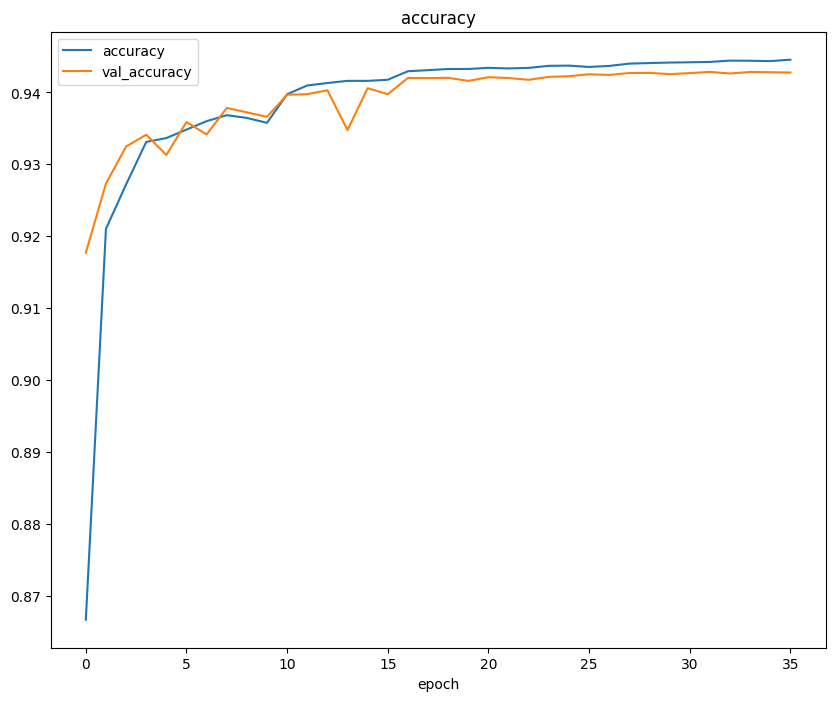

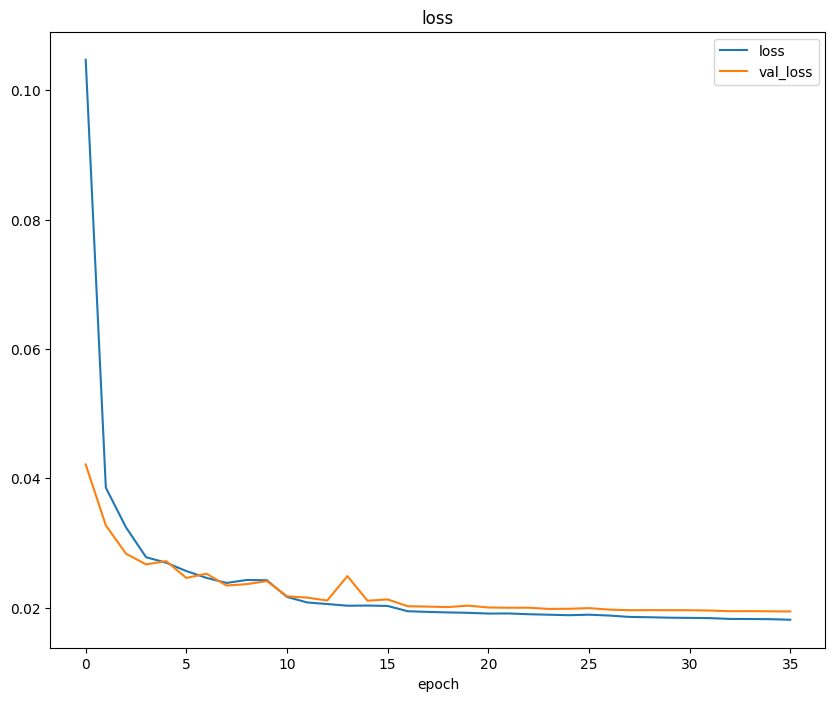

In [12]:
log = pd.read_csv(log_path)

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['accuracy'], label='accuracy')
ax.plot(log['epoch'], log['val_accuracy'], label='val_accuracy')
ax.set_title('accuracy')
ax.set_xlabel('epoch')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(log['epoch'], log['loss'], label='loss')
ax.plot(log['epoch'], log['val_loss'], label='val_loss')
ax.set_title('loss')
ax.set_xlabel('epoch')
ax.legend()

plt.show()

In [15]:
# evaluate model
score = model.evaluate(x=Generator(X_test, y_test, 32, max_sequence_length))
print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

2961/2961 ━━━━━━━━━━━━━━━━━━━━ 41s 14ms/step - accuracy: 0.9449 - loss: 0.0184
Test loss: 0.018213748931884766
Test accuracy: 0.9446537494659424


In [19]:
# print classification report
y_pred = model.predict(x=Generator(X_test, y_test, 32, max_sequence_length))
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred))

2961/2961 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.00      0.00      0.00        17
           2       0.82      0.66      0.73       708
           3       0.91      0.44      0.59       474
           4       1.00      1.00      1.00       401
           5       1.00      1.00      1.00         6
           6       0.00      0.00      0.00         1
           7       0.95      0.97      0.96     20299
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         4
          11       0.95      0.95      0.95        40
          12       1.00      1.00      1.00         1
          15       0.98      0.49      0.65       527
          16       1.00      1.00      1.00        10
          17       1.00      1.00      1.00        55
          18       1.00      1.00   

/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jrosendahl/.virtualenvs/models/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

/tmp/ipykernel_1137890/1876775437.py:5: RuntimeWarning: invalid value encountered in divide
  cm = cm / cm.sum(axis=1)[:, np.newaxis]


(135, 135)
(135,)


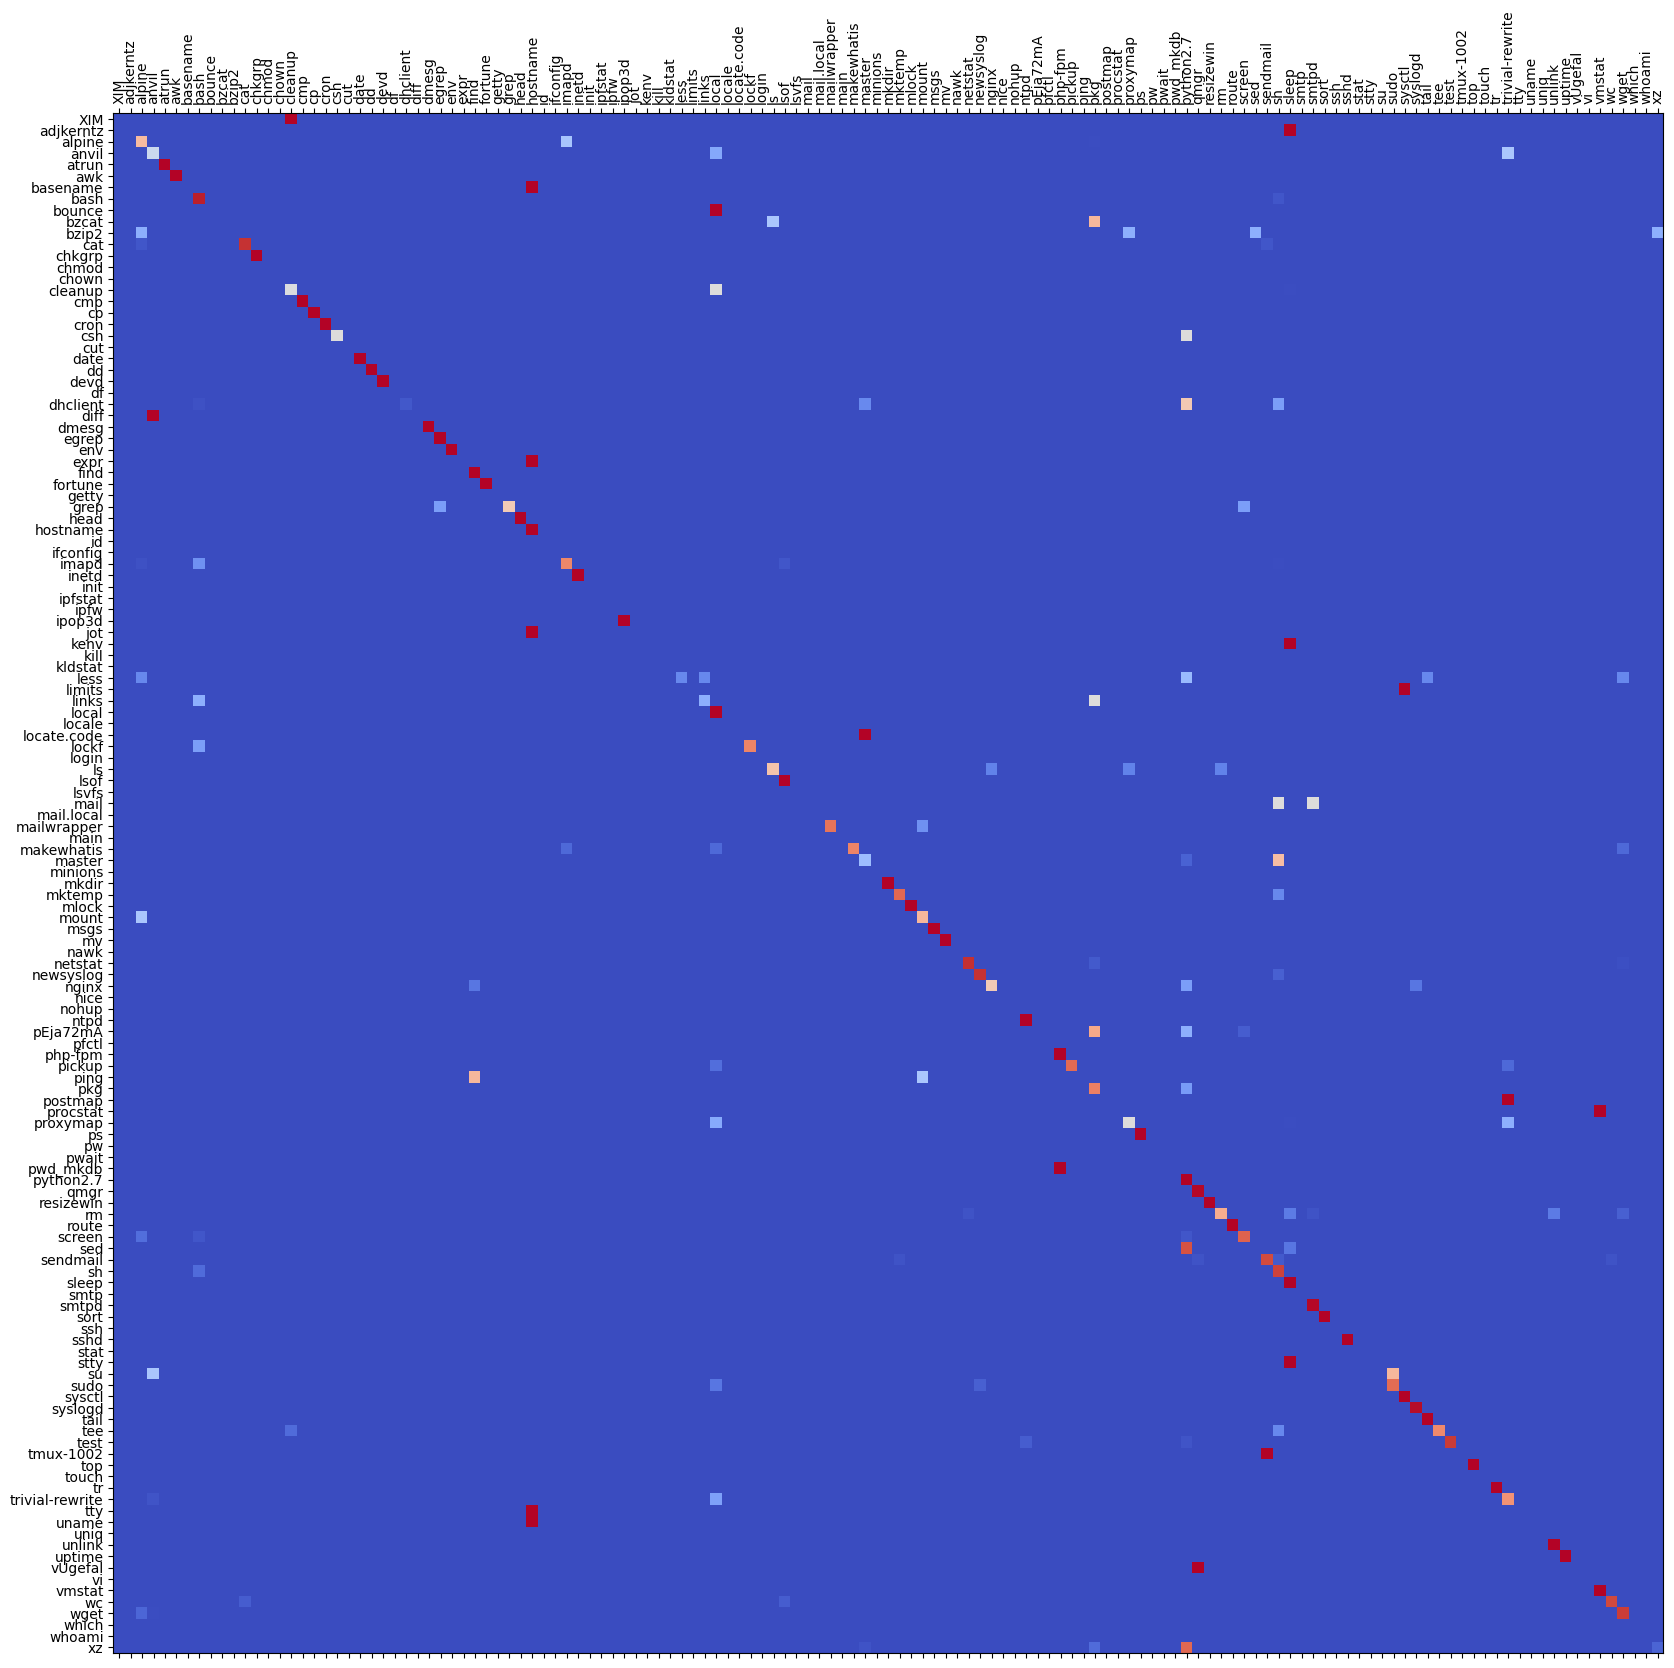

In [37]:
# print confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(no_labels))

# transform to percentage
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# replace all NaN values with 0
cm = np.nan_to_num(cm)

# print cm dimensions
print(cm.shape)
print(distinct_labels.shape)

fig, ax = plt.subplots(figsize=(20, 20))

ax.matshow(cm, cmap='coolwarm', aspect='auto')

# Set class names on axes
ax.set_xticks(range(len(distinct_labels)))
ax.set_yticks(range(len(distinct_labels)))
ax.set_xticklabels(distinct_labels, rotation=90)
ax.set_yticklabels(distinct_labels)

plt.show()

/tmp/ipykernel_1137890/3060038123.py:6: RuntimeWarning: invalid value encountered in divide
  cm = cm / cm.sum(axis=1)[:, np.newaxis]


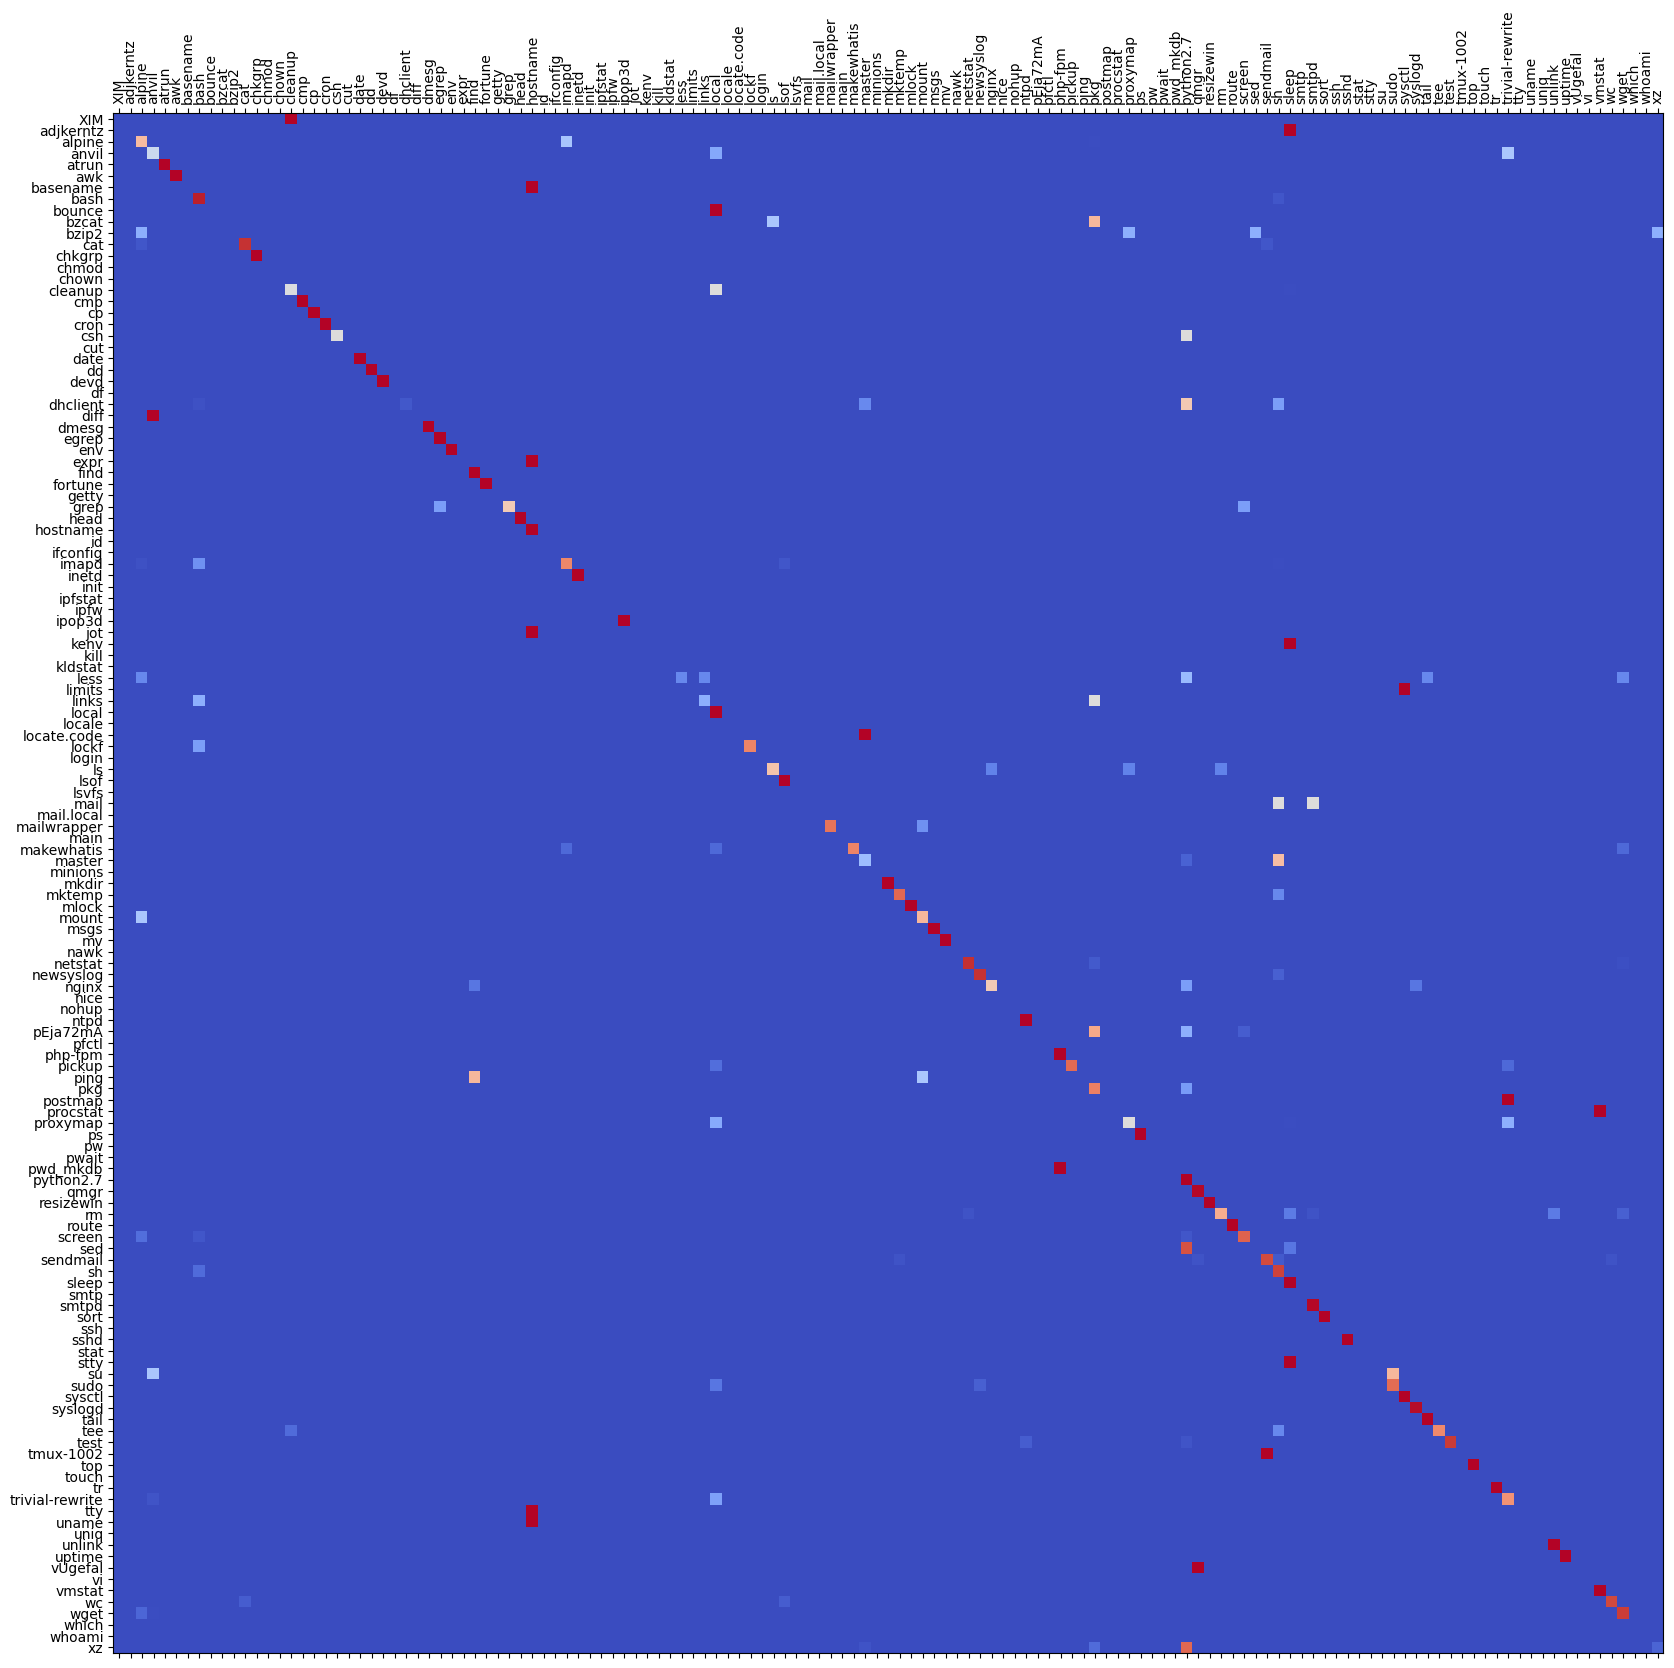

In [38]:
# print confusion matrix
# labels explicitly set, because current model may not predict all labels
cm = confusion_matrix(y_true, y_pred, labels=range(no_labels))

# transform to percentage
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# replace all NaN values with 0
cm = np.nan_to_num(cm)

fig, ax = plt.subplots(figsize=(20, 20))

ax.matshow(cm, cmap='coolwarm', aspect='auto')

# Set class names on axes
ax.set_xticks(range(len(distinct_labels)))
ax.set_yticks(range(len(distinct_labels)))
ax.set_xticklabels(distinct_labels, rotation=90)
ax.set_yticklabels(distinct_labels)

plt.show()

In [39]:
y_pred = model.predict(x=Generator(X_val, y_val, 32, max_sequence_length))

2961/2961 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step


No positive samples for class 6 in y_test. Skipping ROC calculation for this class.
No positive samples for class 13 in y_test. Skipping ROC calculation for this class.
No positive samples for class 14 in y_test. Skipping ROC calculation for this class.
No positive samples for class 26 in y_test. Skipping ROC calculation for this class.
No positive samples for class 37 in y_test. Skipping ROC calculation for this class.
No positive samples for class 41 in y_test. Skipping ROC calculation for this class.
No positive samples for class 43 in y_test. Skipping ROC calculation for this class.
No positive samples for class 44 in y_test. Skipping ROC calculation for this class.
No positive samples for class 45 in y_test. Skipping ROC calculation for this class.
No positive samples for class 47 in y_test. Skipping ROC calculation for this class.
No positive samples for class 50 in y_test. Skipping ROC calculation for this class.
No positive samples for class 53 in y_test. Skipping ROC calculati

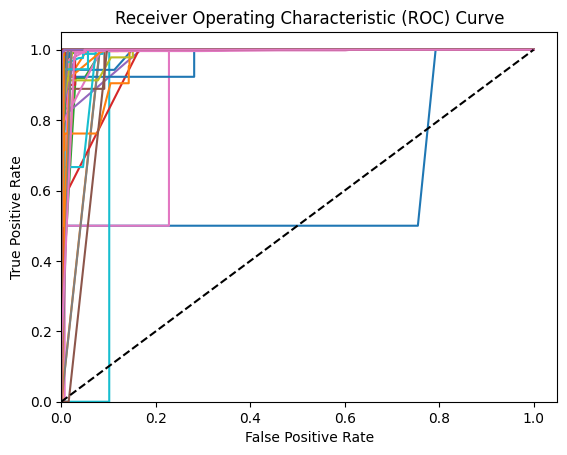

In [40]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(no_labels):
    if np.sum(y_val[:, i]) == 0:
        print(f'No positive samples for class {i} in y_test. Skipping ROC calculation for this class.')
        continue
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
for i in range(no_labels):
    if i not in fpr:
        continue
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.05])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
# plt.legend(loc="lower right")
plt.show()